<h2><center> <span style = "font-family: Babas; font-size: 2em;"> Spooky Author Identification </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em; font-style: italic"> With GloVe and LSTM </span> </center></h4>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Sugata Ghosh </span> </center></h4>

---

### Overview

Suppose that we are given a specific text and we only know that the author of the text is one among [**Edgar Allan Poe**](https://en.wikipedia.org/wiki/Edgar_Allan_Poe) $(\text{EAP})$, [**H. P. Lovecraft**](https://en.wikipedia.org/wiki/H._P._Lovecraft) $(\text{HPL})$ and [**Mary Shelley**](https://en.wikipedia.org/wiki/Mary_Shelley) $(\text{MWS})$. How do we predict who wrote the text? More specifically, how to predict the probability that the given text is written by Edgar Allan Poe, and the same for the other two authors?

In this work, we have a large dataset of texts labeled with the true author, who is one among $\text{EAP}$, $\text{HPL}$ and $\text{MWS}$. The objective is to train a model to predict probabilities that a given new text is written by $X$, where $X$ = $\text{EAP}$, $\text{HPL}$ and $\text{MWS}$. We assume that the new text is indeed written by one of the authors, so that the three probabilities add up to $1$. This immediately helps us in classifying the given text as written by a specific author, for instance, we can choose the author with the highest probability of writing the text as a prediction.

We use this problem to illustrate the use of two relevant techniques: [**GloVe**](https://en.wikipedia.org/wiki/GloVe) model for [**word vectorizations**](https://en.wikipedia.org/wiki/Word_embedding) and [**long short-term memory**](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) [**neural network**](https://en.wikipedia.org/wiki/Artificial_neural_network) for **model building**. The steps in this notebook towards the mentioned objective are as follows:

- We define the `multiclass_log_loss` function, which takes in a matrix of binarized true target classes `y_true_binarized`, a matrix of predicted class probabilities `y_pred_probabilities` and a clipping parameter `epsilon`, and produce the multiclass version of the [**log loss**](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss) metric between `y_true_binarized` and `y_pred_probabilities`. To utilize this function as [**loss**](https://keras.io/api/losses/) in **model compilation**, we use [**TensorFlow**](https://en.wikipedia.org/wiki/TensorFlow) and **Keras backend** functions to write it, instead of the standard [**NumPy**](https://en.wikipedia.org/wiki/NumPy) functions.

- We [**split the data**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) in $80:20$ ratio (the [**training set**](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) consisting of $80\%$ data, and the [**validation set**](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) consisting of the rest). We [**stratify**](https://en.wikipedia.org/wiki/Stratified_sampling) the split using the labels, so that the proportion of each label remains roughly the same in the training set and the validation set.

- We encode the labels $\text{EAP}$, $\text{HPL}$ and $\text{MWS}$ using a dictionary and map them to integer values $0$, $1$ and $2$, respectively; and convert the integer **label vectors** to **binary class matrices**, each row of which represents a [**one-hot**](https://en.wikipedia.org/wiki/One-hot) vector, corresponding to an integer component of the label vector.

- We fit [**Keras tokenizer**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) on the combined list of texts from the training set and the validation set. The obtained words are then indexed by employing the **word_index** method; convert the texts to sequences of integers using the **texts_to_sequences** method; and use the [**pad_sequences**](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) function of [**Keras**](https://en.wikipedia.org/wiki/Keras) to pad the sequences to a maximum length to be equal to the smallest integer greater than $m + 2s$, where $m$ and $s$ respectively denote the [**mean**](https://en.wikipedia.org/wiki/Mean) and [**standard deviation**](https://en.wikipedia.org/wiki/Standard_deviation) of the text lengths from the combined set of texts from the training set and the validation set. We construct a matrix of vector representations of the words found in the training set and the validation set by mapping the words to a $100$-dimensional vector space through **GloVe embedding**.

- We build a [**sequential model**](https://www.tensorflow.org/guide/keras/sequential_model) consisting of an [**embedding layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) with weights provided by the matrix of word vectors, constructed previously; a [**SpatialDropout1D layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SpatialDropout1D); an [**LSTM layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) with number of units same as the length of the GloVe vectors; two [**dense**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) **hidden layers** with [**ReLU**](https://www.tensorflow.org/api_docs/python/tf/nn/relu) [**activation function**](https://en.wikipedia.org/wiki/Activation_function), each followed by a **dropout layer**; and an **output layer** of three [**neurons**](https://en.wikipedia.org/wiki/Artificial_neuron), corresponding to the three probabilities for the three authors, with [**softmax**](https://en.wikipedia.org/wiki/Softmax_function) activation function. The model is compiled with the manually defined `multiclass_log_loss` function as **loss** and the [**Adam**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) [**optimizer**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/) with an initial learning rate of $0.001$, which is then regulated by a [**learning rate scheduler**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) **callback**, which employs a manually defined [**schedule**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) function `scheduler_modified_exponential` to update the [**learning rate**](https://en.wikipedia.org/wiki/Learning_rate) for the optimizer at each epoch.

- We fit the model on the padded sequences generated from the training texts and the binary class matrix generated from the training labels for a set number of epochs. The training loss and the validation loss is monitored at each epoch and we stop the training procedure once the validation loss stops improving via an [**early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) [**callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/). We produce a plot depicting how the training loss and the validation loss evolved over epochs, giving an overall picture of the model building procedure.

- We employ the trained model to predict the probabilities of the texts, in both the training set and the validation set, being written by the three authors and obtain a training log loss of $0.391$ and validation log loss of $0.581$. The predicted probabilities are then converted to labels by picking the **mode** and we get a training [**accuracy**](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) of $0.846$ and validation accuracy of $0.764$. Note that these results are not exactly reproducible as there are inherent randomness in the modeling procedure. Finally, a complete picture of the performance of the trained model on the validation set, in the context of the task of classifying the texts as written by one of the three authors, is provided through a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix).
---


### Contents

- **Data**
- **Project Objective**
- **Evaluation Metric**
- **Train-Validation Split**
- **Manual Encoding of Labels**
- **Word Vectorization**
- **GloVe**
- **Label Vector $\to$ Binary Class Matrix**
- **Text Tokenization and Word Indexing**
- **Text $\to$ Sequence**
- **Sequence $\to$ Padded Sequence**
- **Matrix of Word Vectors**
- **LSTM**
- **Model Building**
- **Prediction and Evaluation**
- **Acknowledgements**
- **References**
- **Further Reading**

### Importing Libraries

In [1]:
%%capture
import math, time, psutil, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.utils import np_utils
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.layers import SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

### Runtime and memory usage

In [2]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

## Data

The [**dataset**](https://www.kaggle.com/competitions/spooky-author-identification/data) used in the notebook is taken from the [**Spooky Author Identification**](https://www.kaggle.com/c/spooky-author-identification) competition, hosted by [**Kaggle**](https://www.kaggle.com/). In particular, we use only the training data, which are labeled, contained in the file **train.csv**. The rest of the data are not used in this notebook.

In [3]:
# Loading the data
data = pd.read_csv('/kaggle/input/spooky-author-identification/train.zip')
print(f"Memory usage : {data.memory_usage().sum()/(1024*1024):.2f} MB")
print(f"Dataset shape: {data.shape}")
data.head()

Memory usage : 0.45 MB
Dataset shape: (19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
# Example of text
data['text'][0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

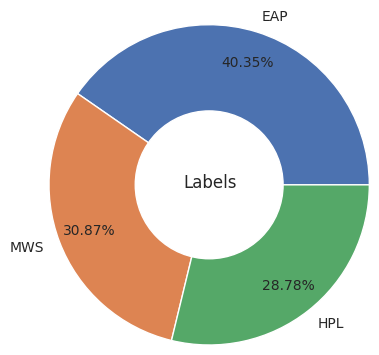

In [5]:
# Frequency comparison of labels
plt.figure(figsize = (6, 4))
ax = plt.subplot(1, 1, 1)
plt.pie(
    data['author'].value_counts(),
    labels = data['author'].value_counts().index,
    autopct = '%1.2f%%',
    pctdistance = 0.8,
    shadow = False,
    radius = 1.3,
    textprops = {'fontsize' : 10}
)
circle = plt.Circle((0, 0), 0.6, fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(circle)
ax.text(-0.21, -0.025, 'Labels', fontsize = 12)
ax.set_xlabel('')
# plt.suptitle("Frequency comparison of labels", fontsize = 12)
plt.subplots_adjust(wspace = 0.4)
plt.show()

## Project Objective

The objective is to train an **LSTM** model with the help of **GloVe** embeddings, to predict probabilities that a given new text $T$ (which is assumed to be written by one among $\text{EAP}$, $\text{HPL}$ and $\text{MWS}$), is written by $X$, where $X$ = $\text{EAP}$, $\text{HPL}$ and $\text{MWS}$. Furthermore, these probabilities are to be used to predict the author of $T$, in a [**multiclass classification**](https://en.wikipedia.org/wiki/Multiclass_classification) setup.

## Evaluation Metric

In this notebook, we use the multiclass version of the **log loss** metric for evaluation of model performances, following the evaluation procedure of the original Kaggle competition. For [**binary classification**](https://en.wikipedia.org/wiki/Binary_classification) with a true class $y \in \{0, 1\}$ and a probability estimate $p = P\{y = 1\}$, the log loss per sample is given by

$$L_{\log}(y, p) = - y\log(p) - (1 - y)\log(1 - p). \tag{1}$$

This extends to the multiclass case as follows. Let there be $N$ sample observations, each to be classified to one among $K$ possible classes. The true classes for the set of observations can be encoded as a binary indicator matrix $Y_{N \times K}$, given by

$$ y_{i,k} = \begin{cases}
                 1, & \text{ if class } k \text{ is the true class of observation } i, \\
                 0, & \text{ if class } k \text{ is not the true class of observation } i,
             \end{cases} $$

for $i = 1,2,\ldots,N$. Thus, each row of the matrix $Y$ has exactly one element as $1$, the rest being $0$. Let $P_{N \times K}$ be a matrix of probability estimates, with

$$p_{i,k} = P\{y_{i,k} = 1\},$$

for $k = 1,2,\ldots,K$, for $i = 1,2,\ldots,N$. Then the log loss for the set of $N$ observations is given by

$$ L_{\log}(Y, P) = - \frac{1}{N} \sum_{i=0}^{N-1} \sum_{k=0}^{K-1} y_{i,k} \log p_{i,k}. \tag{2}$$

Note that in the binary case, we have $p_{i,0} = 1 - p_{i,1}$ and $y_{i,0} = 1 - y_{i,1}$. Expanding the inner sum over $y_{i,k} \in \{0,1\}$ reduces to the expression in the right hand side of $(2)$ to the binary log loss for the set of $N$ observations. See the [**sklearn.metrics.log_loss**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) documentation for details on the implementation. For computing the multiclass log loss, given in $(2)$, we can rewrite the equation as follows

$$ L_{\log}(Y, P) = - \frac{\text{sum of the elements of }Y \odot \log P}{N}, \tag{3}$$

where $\log P$ is the matrix of logarithms of the elements of $P$, given by

$$ \log P = \begin{pmatrix}
\log p_{1,1} & \log p_{1,2} & \cdots & \log p_{1,K} \newline
\log p_{2,1} & \log p_{2,2} & \cdots & \log p_{2,K} \newline
\vdots & \vdots & \ddots & \vdots \newline
\log p_{N,1} & \log p_{N,2} & \cdots & \log p_{N,K}
\end{pmatrix}, $$

and the $\odot$ operator produces the **Hadamard product**, also known as the **element-wise product** or **Schur product**, of two matrices of the same shape, given by

$$ \begin{pmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,n} \newline
x_{2,1} & x_{2,2} & \cdots & x_{2,n} \newline
\vdots & \vdots & \ddots & \vdots \newline
x_{m,1} & x_{m,2} & \cdots & x_{m,n}
\end{pmatrix} \odot \begin{pmatrix}
y_{1,1} & y_{1,2} & \cdots & y_{1,n} \newline
y_{2,1} & y_{2,2} & \cdots & y_{2,n} \newline
\vdots & \vdots & \ddots & \vdots \newline
y_{m,1} & y_{m,2} & \cdots & y_{m,n}
\end{pmatrix} = \begin{pmatrix}
x_{1,1}y_{1,1} & x_{1,2}y_{1,2} & \cdots & x_{1,n}y_{1,n} \newline
x_{2,1}y_{2,1} & x_{2,2}y_{2,2} & \cdots & x_{2,n}y_{2,n} \newline
\vdots & \vdots & \ddots & \vdots \newline
x_{m,1}y_{m,1} & x_{m,2}y_{m,2} & \cdots & x_{m,n}y_{m,n}
\end{pmatrix}. $$

In the next code block, we write a function computing the multiclass log loss, using the representation given in $(3)$. For this purpose, we use different functions from the [**tensorflow.keras.backend**](https://www.tensorflow.org/api_docs/python/tf/keras/backend) module.

**Note:** An issue may arise if we have a predicted class probability as $0$ (since $\log 0$ is undefined) or $1$ (since it necessitates other class probabilities to be $0$). For this reason, we clip the predicted class probabilities inside an interval $(\epsilon, 1 - \epsilon)$, for a small positive real number $\epsilon$. In other words, if a probability value is less than $\epsilon$, we substitute it with $\epsilon$. Similarly, if a probability value is greater than $1 - \epsilon$, we substitute it with $1 - \epsilon$. By definition, for the interval to be nonempty, we must have $\epsilon < 0.5$. In practice, we choose it to be much smaller, close to $0$. To summarize, we make the following transformation to each predicted class probability $p$:

$$ p \mapsto \max{\left(\min{\left(p, 1 - \epsilon\right)}, \epsilon\right)}. $$

Here, the default value of $\epsilon$ is taken to be $10^{-20}$.

In [6]:
def multiclass_log_loss(y_true_binarized, y_pred_probabilities, epsilon = 1e-20):
    """
    Computes the multiclass version oLf Log Loss metric
    Args:
        y_true_binarized (array_like, shape (m, n_class)): Matrix of binarized true target classes
        y_pred_probabilities (array_like, shape (m, n_class)): Matrix of predicted class probabilities
        eps (scalar): Clipping parameter for predicted class probabilities
            Class probabilities outside the interval (eps, 1 - eps) are clipped to the nearest endpoint
    Returns:
        logloss (scalar): Multiclass log loss obtained from y_true and y_pred (eps-clipped)
    """
    # Clipping to avoid undefined quantity log 0
    y_pred_probabilities = K.clip(y_pred_probabilities, epsilon, 1 - epsilon)
    
    # Casting sum of the elements of Hadamard product in (3)
    sum_ = tf.cast(K.sum(y_true_binarized * K.log(y_pred_probabilities)), tf.float64)
    
    # Computing log loss
    logloss = (-1 / len(y_true_binarized)) * sum_
    
    return logloss

We give an example with $N = 4$ observations and $K = 3$ classes. Given the true classes $(Y)$, the multiclass Log Loss is computed for a bad set of probability estimates $(P_{\text{bad}})$ and a good set of probability estimates $(P_{\text{good}})$.

In [7]:
# Examples
y_true = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 0]])
y_pred_bad = np.array([[0.1, 0.4, 0.5], [0.2, 0.1, 0.7], [0.6, 0.3, 0.1], [0.2, 0.2, 0.6]])
y_pred_good = np.array([[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.1, 0.0, 0.9], [0.1, 0.8, 0.1]])

print(f"Log Loss for bad predictions: {multiclass_log_loss(y_true, y_pred_bad):.4f}")
print(f"Log Loss for good predictions: {multiclass_log_loss(y_true, y_pred_good):.4f}")

Log Loss for bad predictions: 2.1293
Log Loss for good predictions: 0.2271


## Train-Validation Split

The dataset is split in $80:20$ ratio, with the **training set** consisting of $80\%$ of the data, and the **validation set** consisting of the rest. The split is stratified using the labels to keep the label proportions approximately equal in the training set and the validation set.

In [8]:
# Train-validation split
x, y = data['text'].values, data['author'].values
x_train, x_valid, y_train, y_valid = train_test_split(x, y, 
                                                      stratify = y, 
                                                      random_state = 40, 
                                                      test_size = 0.2, 
                                                      shuffle = True)

## Manual Encoding of Labels

We observe that the labels (authors) are [**nominal**](https://en.wikipedia.org/wiki/Nominal_category) in nature, i.e. they do not have an inherent [**order**](https://en.wikipedia.org/wiki/Order_theory). To encode the labels, we use a dictionary to map them to integer values in the following way: $\text{EAP} \mapsto 0$, $\text{HPL} \mapsto 1$ and $\text{MWS} \mapsto 2$.

In [9]:
# Manual encoding of labels
label_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = pd.Series(y_train).replace(label_dict, inplace = False).values
y_valid = pd.Series(y_valid).replace(label_dict, inplace = False).values

## Word Vectorization

In [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP), we generally deal with text data in string format. However, machine learning models typically take vectors (arrays of numbers) as input. Thus, to apply the tools of machine learning to problems involving text data, it is crucial to come up with a strategy to convert strings/texts to numbers. **Word vectorizations** are a class of techniques where individual words are represented as real-valued vectors in a predefined [**vector space**](https://en.wikipedia.org/wiki/Vector_space). Typically, the representation encodes the meaning of the word in such a way that words that are similar in meaning have representations that are closer in the vector space.

## GloVe

In this project, we use the **GloVe** model for word vectorization. GloVe, which stands for Global Vectors, is developed as [**an open-source project at Stanford**](https://nlp.stanford.edu/projects/glove/), launched in $2014$. It is an [**unsupervised learning**](https://en.wikipedia.org/wiki/Unsupervised_learning) [**algorithm**](https://en.wikipedia.org/wiki/Algorithm) to get vector representations for words. It works by mapping words into a vector space in such a way that the semantic similarity of two words is reflected in the distance between their respective vector representations. The model is trained on aggregated global word-word [**co-occurrence matrix**](https://en.wikipedia.org/wiki/Co-occurrence_matrix) from a corpus, and the resulting representations showcase interesting linear substructures of the vector space. As [**log-bilinear regression model**](https://jiangnanhugo.github.io/blog/log-bilinear-model) for unsupervised learning of word representations, it combines the features of two model families, namely the **global matrix factorization** and **local context window** methods. In the following code block, we load the GloVe vectors and store them in a dictionary for future use. We report the total number of word vectors found. As example, we show the vector representation of the word *the*. Observe that the word is mapped to a vector space of dimension $100$.

In [10]:
# Loading the GloVe vectors in a dictionary
embed_glove = {}
glove_6b_100d = open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')
for line in glove_6b_100d:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype = 'float32')
    embed_glove[word] = vector
glove_6b_100d.close()

print(f"Number of word vectors: {len(embed_glove)}")

Number of word vectors: 400000


In [11]:
# Example of vector representation of a word
print("Word: 'the'")
print("Vector representation:")
print(embed_glove['the'])

Word: 'the'
Vector representation:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.5

In [12]:
# Dimension of the word vectors
dim_glove = len(embed_glove['the'])
print(f"Dimension: {dim_glove}")

Dimension: 100


<a name='Label-Vector-to-Binary-Class-Matrix'></a>
## Label Vector $\to$ Binary Class Matrix

We convert the integer **label vectors** of training set and validation set to **binary class matrices**. Essentially, we map the integer labels to **one-hot** vectors. This can be achieved by encoding $0$ as $(1, 0, 0)$, $1$ as $(0, 1, 0)$ and $2$ as $(0, 0, 1)$. For example, we have

$$ \begin{pmatrix}
0 \newline
1 \newline
2 \newline
1
\end{pmatrix} \mapsto \begin{pmatrix}
1 & 0 & 0 \newline
0 & 1 & 0 \newline
0 & 0 & 1 \newline
0 & 1 & 0
\end{pmatrix} $$

In [13]:
# Binarization of the labels
y_train_matrix = np_utils.to_categorical(y_train)
y_valid_matrix = np_utils.to_categorical(y_valid)

# Example
print(f"Original label: {y_train[0]}")
print(f"Encoded label : {list(y_train_matrix[0])}")

Original label: 1
Encoded label : [0.0, 1.0, 0.0]


## Text Tokenization and Word Indexing

We fit **Keras tokenizer** on the combined list of training texts and validation texts using the **fit_on_texts** method. The words, thence obtained, are then indexed by employing the **word_index** method.

In [14]:
# Tokenization and indexing using keras tokenizer
token = text.Tokenizer(num_words = None)
token.fit_on_texts(list(x_train) + list(x_valid))
word_index = token.word_index

# Example
print(f"Index of the word 'seven': {word_index['seven']}")
print(f"Number of indexed words  : {len(word_index)}")

Index of the word 'seven': 942
Number of indexed words  : 25943


<a name='Text-to-Sequence'></a>
## Text $\to$ Sequence

Next, we use the **texts_to_sequences** method of **Keras tokenizer**, which is fit to the texts found in both the training set and the validation set, to convert these texts to sequences of integers. To be precise, a text, which is a sequence of words, is converted to the sequence of indices of those words. The tranformation is demonstrated in the next example and then implemented on the texts in training set and validation set.

In [15]:
# Example
text_ = 'the seven deadly sins'
tokens = text_.split(" ")
sequence_ = [word_index[x] for x in tokens]

print(f"Text    : {text_}")
print(f"Tokens  : {tokens}")
print(f"Sequence: {sequence_}")

Text    : the seven deadly sins
Tokens  : ['the', 'seven', 'deadly', 'sins']
Sequence: [1, 942, 2674, 12261]


In [16]:
# Converting to sequence
x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# Example
print(f"Text: {x_train[0]}")
print("Converted to sequence:")
print(x_train_seq[0])

Text: The archaic lanes and houses and unexpected bits of square and court had indeed delighted me, and when I found the poets and artists to be loud voiced pretenders whose quaintness is tinsel and whose lives are a denial of all that pure beauty which is poetry and art, I stayed on for love of these venerable things.
Converted to sequence:
[1, 3695, 4245, 3, 500, 3, 2545, 6589, 2, 1438, 3, 1943, 12, 156, 2678, 22, 3, 41, 6, 93, 1, 3103, 3, 5924, 4, 28, 1268, 10108, 16050, 131, 16051, 25, 12278, 3, 131, 1299, 56, 5, 5925, 2, 32, 9, 1176, 323, 18, 25, 5390, 3, 668, 6, 3938, 27, 17, 152, 2, 67, 2945, 139]


<a name='Sequence-to-Padded-Sequence'></a>
## Sequence $\to$ Padded Sequence

Before we feed these sequences to the model, it is beneficial to make all the sequences in the training set and the validation set to fit a given standard length. For this purpose, it is necessary to pad or truncate some sequences. In **Keras**, the **pad_sequences** function takes a batch of input sequences and implements a technique which make the size of the sequences equal to either a pre-specified maximum length or the length of the longest individual sequence. The process involves adding zeros to a specified position of a sequence or truncating from a specified end of a sequence. Here we have set the maximum length to be equal to the smallest integer greater than $m + 2s$, where $m$ is the mean of the text lengths (training set and validation set combined) and $s$ is the standard deviation of the text lengths.

In [17]:
# Sequence padding
len_train = [len(x_train_seq[i]) for i in range(len(x_train_seq))]
len_valid = [len(x_valid_seq[i]) for i in range(len(x_valid_seq))]
len_ = np.array(len_train + len_valid)
maxlen_ = math.floor(len_.mean() + 2*len_.std()) + 1

x_train_pad = sequence.pad_sequences(x_train_seq, 
                                    maxlen = maxlen_, 
                                    padding = 'pre', 
                                    truncating = 'pre', 
                                    value = 0.0)

x_valid_pad = sequence.pad_sequences(x_valid_seq, 
                                    maxlen = maxlen_, 
                                    padding = 'pre', 
                                    truncating = 'pre', 
                                    value = 0.0)

# Example (continued from the previous code block)
print(x_train_pad[0])
print(f"Maximum length: {maxlen_}")

[    0     0     0     0     0     0     0     1  3695  4245     3   500
     3  2545  6589     2  1438     3  1943    12   156  2678    22     3
    41     6    93     1  3103     3  5924     4    28  1268 10108 16050
   131 16051    25 12278     3   131  1299    56     5  5925     2    32
     9  1176   323    18    25  5390     3   668     6  3938    27    17
   152     2    67  2945   139]
Maximum length: 65


## Matrix of Word Vectors

Next, we construct a matrix which contains vector representations (obtained through the GloVe model) of the words found in the training set and the validation set. In general, if we have $M$ words and their respective vector representations, each of dimension $N$, then the resulting matrix, containing word representations as rows, has dimension $M \times N$.

In [18]:
# Matrix of vector representations of the words in training set and validation set
word_vectorization_matrix = np.zeros((len(word_index) + 1, dim_glove))
for word, i in word_index.items():
    word_embed_vector = embed_glove.get(word)
    if word_embed_vector is not None:
        word_vectorization_matrix[i] = word_embed_vector

print(f"Shape of the matrix of word vectors: {word_vectorization_matrix.shape}")

Shape of the matrix of word vectors: (25944, 100)


## LSTM

The human brain learns in a cumulative manner. For instance, while studying a physics book, one learns the first chapter, and then learns the second chapter based on the understanding of the previous chapter. [**Recurrent neural networks**](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN) function in a similar fashion, in the sense that they retain the previous information and use it for processing the current input data. However, in practice, general RNNs are not good at learning **long-term dependencies**. To explain this, we take an example from [**Christopher Olah**](https://colah.github.io/about.html)'s excellent blog post [**Understanding LSTM Networks**](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). Consider the following text:
```
"I grew up in France... I speak fluent ____."
```
The goal is to predict the last word in the blank. The correct word is *French*. Now, if we only take the preceding word *fluent*, or the bigram *speak fluent*, or even the trigram *I speak fluent*, it only indicates that the word is likely to be the name of a particular language. If we need to find the specific language, then we require the word *France*, which is further away from the word to be predicted. However, the dependence of the two words is clear. This is how **long-term dependencies** work. The distance between the relevant information and the point where it is required in the context of the given problem can become very large. As this distance becomes large, RNNs may be unable to learn to connect the two entities, resulting in inaccurate predictions. The reason of this inability can be traced back to the [**vanishing gradient problem**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). To resolve this, many variants of RNN were developed. The most famous one, perhaps, is the **long short-term memory**, introduced by [**Sepp Hochreiter**](https://en.wikipedia.org/wiki/Sepp_Hochreiter) and [**Jurgen Schmidhuber**](https://en.wikipedia.org/wiki/J%C3%BCrgen_Schmidhuber) in $1997$. For a detailed treatment on how LSTM works, the reader is referred to the previously mentioned [**blog post**](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by **Christopher Olah**.

## Model Building

We build a **sequential model** with the following layers:

- An **embedding layer** with the matrix of word vectors, constructed previously, providing the weights. In the present context, it transforms each word index in a sequence obtained from a text, to the corresponding GloVe vector for the word, thus converting a sequence to a two-dimensional array_like object. The parameters in this layer are non-trainable.

- A **SpatialDropout1D layer**, differing from usual [**dropout layers**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) in the fact that it drops entire slice of an input tensor (along a specific axis) instead of individual elements. For instance, in usual dropout, each of the eight elements in an input tensor with the shape $(2, 2, 2)$ may become zeroed out depending on the outcome of a random coin flip (with specified probability of getting head). There will be $8$ independent coin flips in total, and any number of values, from $0$ to $8$, may result in a zero. However, there are times when it may be necessary to drop the entire slice along axis $0$, meaning that if one element is dropped, the others along the same axis must also be dropped. The number of zeroed elements in this case can be $0$, $2$, $4$, $6$, or $8$, and the dropout only requires four independent random coin flips, as each dropped element drags its twin down axis $0$. This mechanism is particularly useful when dealing with slices that are strongly correlated and we may need to drop along specific axes to promote independence among the remaining slices.

- An **LSTM layer** having number of units equal to the length of the GloVe vectors, with specified **dropout** (fraction of the units to drop for the linear transformation of the inputs) and **recurrent_dropout** (fraction of the units to drop for the linear transformation of the recurrent state)

- Two **dense** **hidden layers** with **ReLU** **activation**, each followed by a **dropout layer**

- An **output layer** of three [**neurons**](https://en.wikipedia.org/wiki/Artificial_neuron) (for three probabilities corresponding to the three authors) with [**softmax**](https://en.wikipedia.org/wiki/Softmax_function) activation

In [19]:
# LSTM with GloVe embeddings
model = Sequential()
model.add(Embedding(len(word_index) + 1, 
                    dim_glove,
                    weights = [word_vectorization_matrix],
                    input_length = maxlen_,
                    trainable = False))

model.add(SpatialDropout1D(0.3))
model.add(LSTM(dim_glove, dropout = 0.3, recurrent_dropout = 0.3))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.8))

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.8))

model.add(Dense(3, activation = 'softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 65, 100)           2594400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 65, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

Now, we configure the model with the `multiclass_log_loss` function, defined in the **Evaluation Metric** section, and **Adam** **optimizer**.

In [20]:
# Model compilation
initial_learning_rate = 0.001
model.compile(loss = multiclass_log_loss, 
              optimizer = tf.keras.optimizers.Adam(learning_rate = initial_learning_rate))

We use the **early stopping** **callback** to monitor the validation loss and stop the training once it stops improving by a specified margin for a specified number of epochs.

In [21]:
# Early stopping callback
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.001, 
                          patience = 20, 
                          verbose = 1, 
                          mode = 'auto',
                          start_from_epoch = 60)

We use the [**learning rate scheduler**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback which employs a [**schedule**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) function to update the [**learning rate**](https://en.wikipedia.org/wiki/Learning_rate) for the optimizer. The schedule function takes the epoch index and the current learning rate as inputs and computes a new learning rate, which is then applied on the optimizer for the next epoch. In this work, we define the functions `scheduler_modified_linear` and `scheduler_modified_exponential` which apply the initial learning rate for a set number of epochs at the beginning and then decrease it linearly and exponentially, respectively. Mathematically, in the modified linear scheduler, we use the constant map $x \mapsto x$ up to a certain number of epochs and thereafter use the following map to update the learning rate:

$$x \mapsto x\left(\frac{100 - \text{epoch}}{100 - \text{epoch} + 1}\right)$$

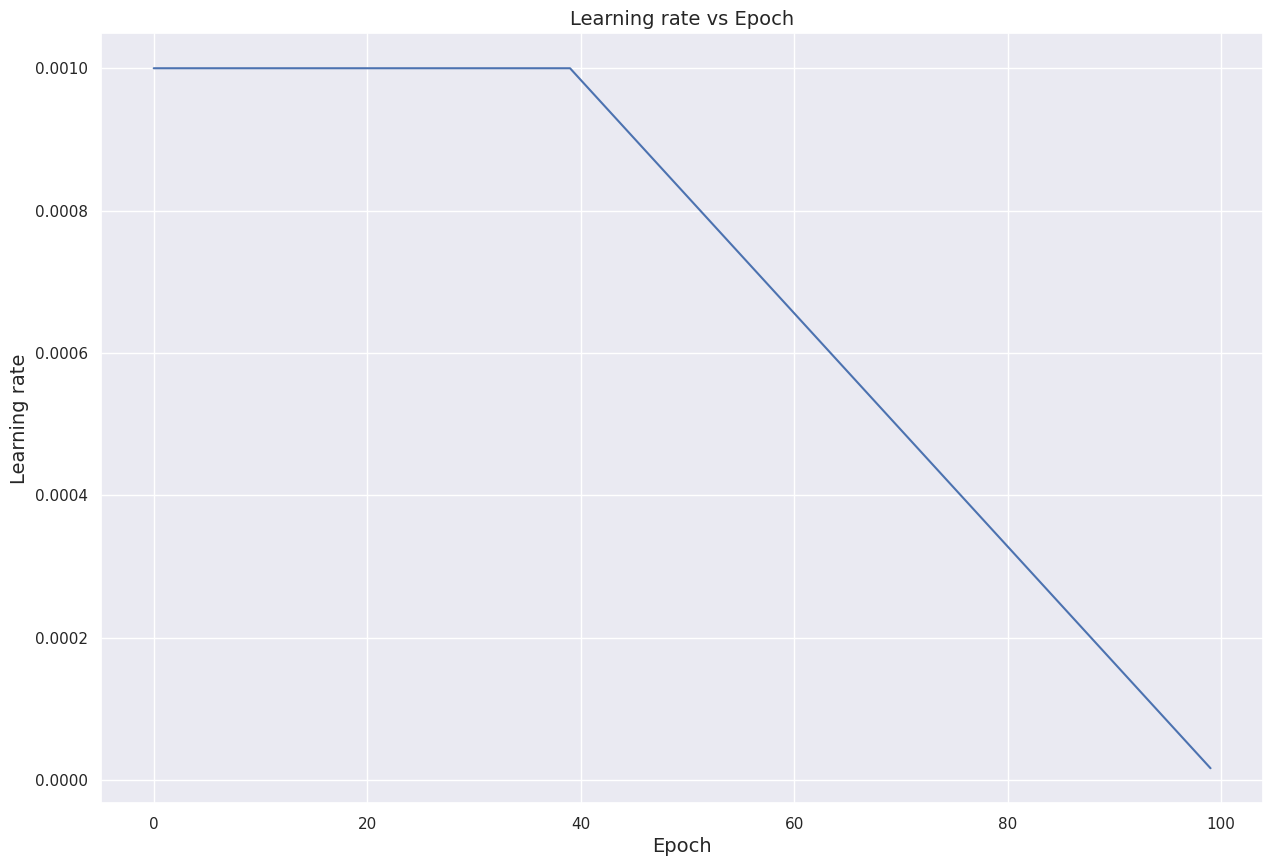

In [22]:
# Modified linear schedule function
def scheduler_modified_linear(epoch, learning_rate):
    if epoch < 40:
        return learning_rate
    else:
        return learning_rate * (100 - epoch) / (100 - epoch + 1)
    
learning_rate, epoch, num_epochs, learning_rate_list = initial_learning_rate, 0, 100, []
for i in range(num_epochs):
    learning_rate = scheduler_modified_linear(epoch, learning_rate)
    learning_rate_list.append(learning_rate)
    epoch += 1
plt.figure(figsize = (15, 10))
plt.plot(learning_rate_list)
plt.title("Learning rate vs Epoch", fontsize = 14)
plt.xlabel("Epoch", fontsize = 14)
plt.ylabel("Learning rate", fontsize = 14)
plt.savefig('learningrate_modified_linear.jpg')
plt.show()

Similarly, in the modified exponential scheduler, we use the constant map $x \mapsto x$ up to a fixed number of epochs and after that employ the following map to update the learning rate:

$$x \mapsto x\exp{(-0.1)}$$

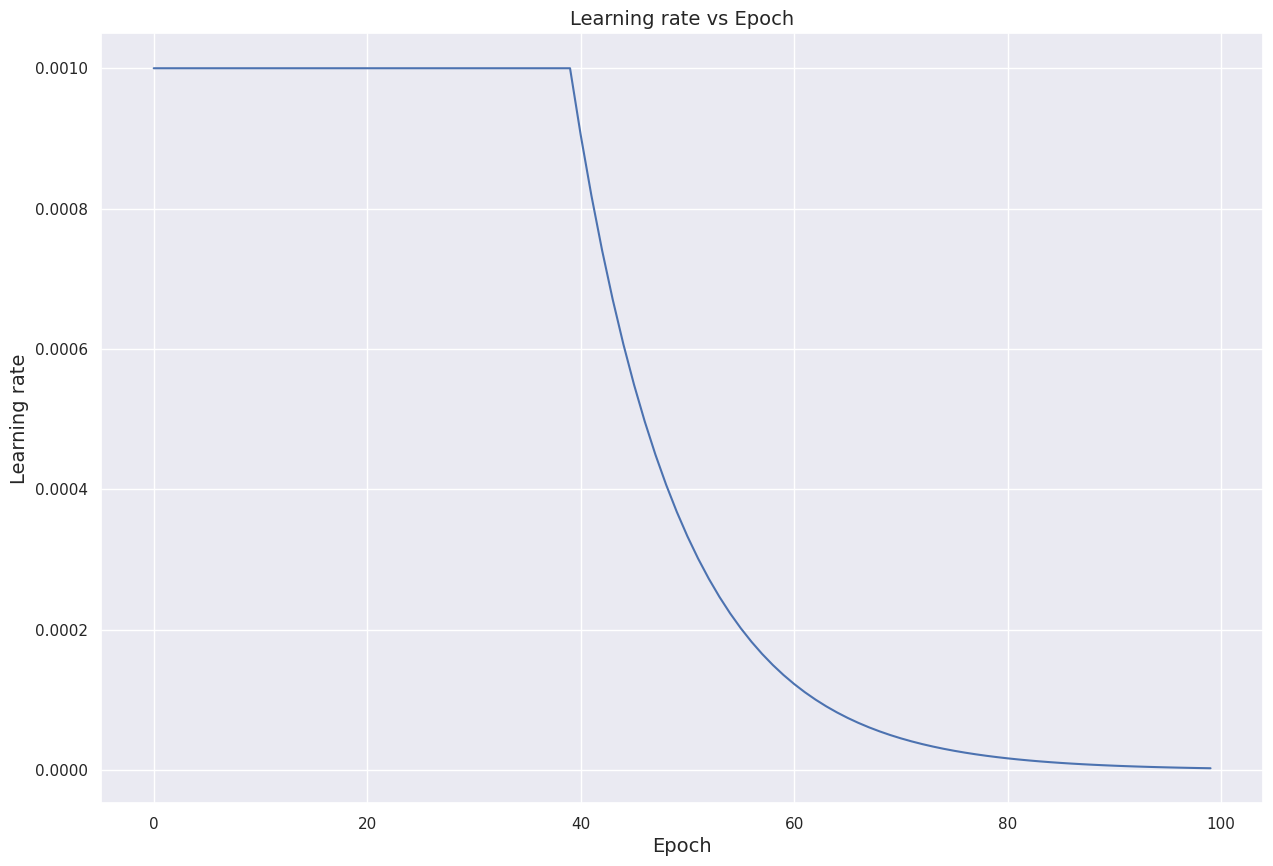

In [23]:
# Modified exponential schedule function
def scheduler_modified_exponential(epoch, learning_rate):
    if epoch < 40:
        return learning_rate
    else:
        return learning_rate * math.exp(-0.1)
    
learning_rate, epoch, num_epochs, learning_rate_list = initial_learning_rate, 0, 100, []
for i in range(num_epochs):
    learning_rate = scheduler_modified_exponential(epoch, learning_rate)
    learning_rate_list.append(learning_rate)
    epoch += 1
plt.figure(figsize = (15, 10))
plt.plot(learning_rate_list)
plt.title("Learning rate vs Epoch", fontsize = 14)
plt.xlabel("Epoch", fontsize = 14)
plt.ylabel("Learning rate", fontsize = 14)
plt.savefig('learningrate_modified_exponential.jpg')
plt.show()

In this notebook, we employ the modified exponential scheduler, but one can experiment with the other schedule functions, including the [**built-in learning rate schedules**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) of Keras.

In [24]:
# Learning rate scheduler callback
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler_modified_exponential)

Next, we fit the the model on padded training sequences `x_train_pad` and binary class matrices `y_train_matrix` generated from training labels. We monitor the validation loss through padded validation sequences `x_valid_pad` and binary class matrices `y_valid_matrix` generated from validation labels, and use it to potentially stop the training early, once the set conditions in the `earlystop` callback is met.

In [25]:
%%time
# Model fitting
history = model.fit(x_train_pad, 
                    y = y_train_matrix, 
                    batch_size = 256, 
                    epochs = 100, 
                    verbose = 0, 
                    validation_data = (x_valid_pad, y_valid_matrix), 
                    callbacks = [earlystop, learning_rate_scheduler])

Epoch 83: early stopping
CPU times: user 1h 31min 9s, sys: 6min 8s, total: 1h 37min 17s
Wall time: 27min 51s


Note that we keep `verbose = 0` to avoid extensive numerical outputs. The relevant information on how the training loss and the validation loss evolve over epochs is depicted in the following diagram.

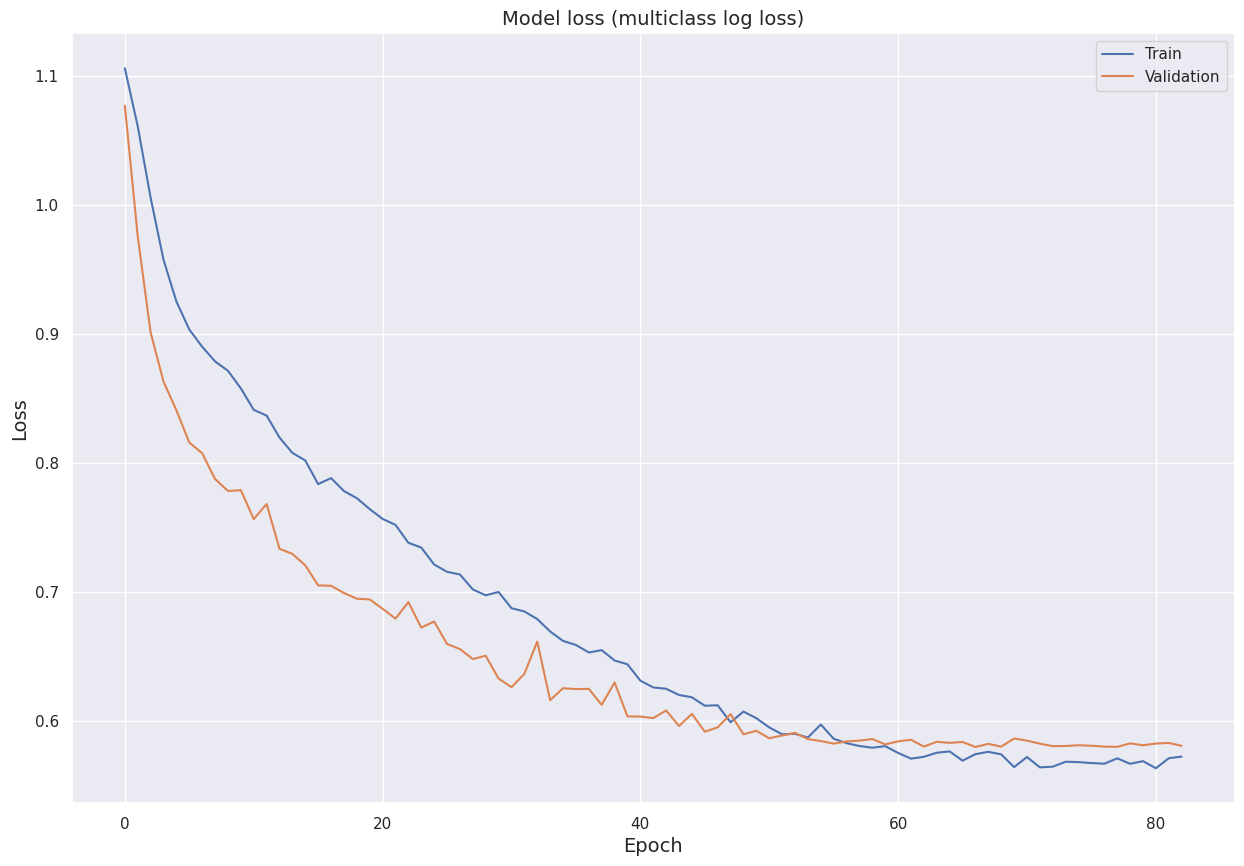

In [26]:
# Visualization of model loss
plt.figure(figsize = (15, 10))
plt.title('Model loss (multiclass log loss)', fontsize = 14)
sns.lineplot(data = history.history['loss'], label = 'Train')
sns.lineplot(data = history.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.legend()
plt.savefig('logloss.jpg')
plt.show()

## Prediction and Evaluation

We use the trained model to predict the probabilities of texts being written by the three authors for both training texts and validation texts. Then we use the `multiclass_log_loss` function to compute the multiclass version of the log loss metric for predictions on both training set and validation set, to evaluate the performance of the model on the two sets. Alternately, we can use the `model.evaluate` function to directly compute the multiclass log loss for predictions on training set and validation set.

In [27]:
# Prediction on the training set and the validation set
y_train_matrix_pred = model.predict(x_train_pad)
y_valid_matrix_pred = model.predict(x_valid_pad)

123/123 [==============================] - 2s 16ms/step


In [28]:
# Log loss
logloss_train = multiclass_log_loss(y_train_matrix, y_train_matrix_pred).numpy()
logloss_valid = multiclass_log_loss(y_valid_matrix, y_valid_matrix_pred).numpy()

# Log loss (computed using model.evaluate)
# logloss_train = model.evaluate(x_train_pad, y_train_matrix, batch_size = 256, verbose = 0)
# logloss_valid = model.evaluate(x_valid_pad, y_valid_matrix, batch_size = 256, verbose = 0)

print(f"Training logloss  : {round(logloss_train, 3)}")
print(f"Validation logloss: {round(logloss_valid, 3)}")

Training logloss  : 0.391
Validation logloss: 0.581


The model gives a probability vector for each text. We use it to classify the text as one written by a specific author from the set of three possible authors. Essentially we choose the author with highest probability of writing the particular text. For example, if the probability vector for a particular text turns out to be $(0.3, 0.4, 0.3)$, then we predict that the text is written by the second author $(\text{HPL})$.

In [29]:
# Converting probability vectors to labels
y_train_true = np.array([np.argmax(x) for x in y_train_matrix])
y_valid_true = np.array([np.argmax(x) for x in y_valid_matrix])
y_train_pred = np.array([np.argmax(x) for x in y_train_matrix_pred])
y_valid_pred = np.array([np.argmax(x) for x in y_valid_matrix_pred])

The classification scheme based on the trained model is evaluated for both training data and validation data, in terms of the **accuracy** metric, which is simply the proportion of correct predictions. Additionally, we report the **confusion matrix** to give a complete representation of the model performance on the validation set, in context of the task of classification.

In [30]:
# Accuracy
match_train = (y_train_true == y_train_pred)
match_train = np.array(list(map(lambda x: int(x == True), match_train)))
match_valid = (y_valid_true == y_valid_pred)
match_valid = np.array(list(map(lambda x: int(x == True), match_valid)))

print(f"Training accuracy  : {round(match_train.sum() / len(match_train), 3)}")
print(f"Validation accuracy: {round(match_valid.sum() / len(match_valid), 3)}")

Training accuracy  : 0.846
Validation accuracy: 0.764


In [31]:
# Function to compute and print confusion matrix
def conf_matrix(y_true, y_pred, n_class, class_names = 'default', figsize = (6.25, 5), font_scale = 1, annot_kws_size = 12):
    if class_names == 'default':
        class_names = np.arange(n_class)
    tick_marks_y = np.arange(n_class) + 0.5
    tick_marks_x = np.arange(n_class) + 0.5
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(n_class), range(n_class))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.savefig('confmat.jpg')
    plt.show()

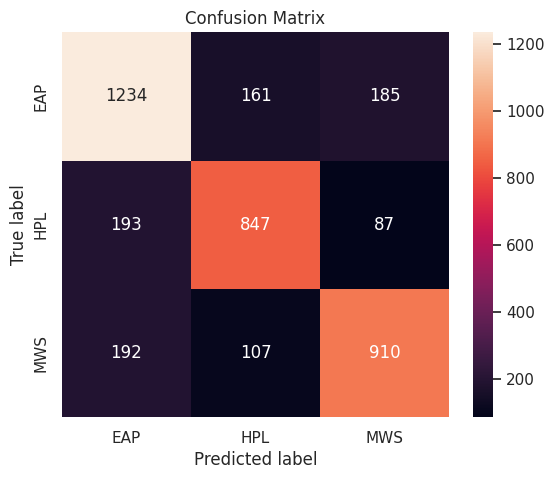

In [32]:
# Confusion matrix
conf_matrix(y_valid_true, y_valid_pred, n_class = 3, class_names = ['EAP', 'HPL', 'MWS'])

## Acknowledgements

- [**Dataset**](https://www.kaggle.com/competitions/spooky-author-identification/data) provided in the Kaggle competition [**Spooky Author Identification**](https://www.kaggle.com/c/spooky-author-identification)
- [**GloVe: Global Vectors for Word Representation**](https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation) dataset by [**Rachael Tatman**](https://www.kaggle.com/rtatman)
- [**How to Choose a Learning Rate Scheduler for Neural Networks**](https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler) by **Yi Li**
- [**Practical Recommendations for Gradient-Based Training of Deep Architectures**](https://arxiv.org/pdf/1206.5533.pdf) by [**Yoshua Bengio**](https://en.wikipedia.org/wiki/Yoshua_Bengio)

## References

- [**Accuracy**](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy)
- [**Activation function**](https://en.wikipedia.org/wiki/Activation_function)
- [**Adam optimizer**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [**Algorithm**](https://en.wikipedia.org/wiki/Algorithm)
- [**Artificial neuron**](https://en.wikipedia.org/wiki/Artificial_neuron)
- [**Binary classification**](https://en.wikipedia.org/wiki/Binary_classification)
- [**Callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/)
- [**Confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix)
- [**Co-occurrence matrix**](https://en.wikipedia.org/wiki/Co-occurrence_matrix)
- [**Dense layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
- [**Dropout layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
- [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- [**Edgar Allan Poe**](https://en.wikipedia.org/wiki/Edgar_Allan_Poe)
- [**Embedding layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
- [**GloVe**](https://en.wikipedia.org/wiki/GloVe)
- [**GloVe: Global Vectors for Word Representation**](https://nlp.stanford.edu/projects/glove/)
- [**H. P. Lovecraft**](https://en.wikipedia.org/wiki/H._P._Lovecraft)
- [**Jurgen Schmidhuber**](https://en.wikipedia.org/wiki/J%C3%BCrgen_Schmidhuber)
- [**Kaggle**](https://www.kaggle.com/)
- [**Keras**](https://en.wikipedia.org/wiki/Keras)
- [**Keras built-in learning rate schedules**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules)
- [**Keras built-in optimizer classes**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/)
- [**Keras tokenizer**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)
- [**Learning rate**](https://en.wikipedia.org/wiki/Learning_rate)
- [**Learning rate scheduler**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)
- [**Log loss**](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)
- [**Log-bilinear model**](https://jiangnanhugo.github.io/blog/log-bilinear-model)
- [**Long short-term memory**](https://en.wikipedia.org/wiki/Long_short-term_memory)
- [**Loss**](https://keras.io/api/losses/)
- [**LSTM layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
- [**Mary Shelley**](https://en.wikipedia.org/wiki/Mary_Shelley)
- [**Mean**](https://en.wikipedia.org/wiki/Mean)
- [**Multiclass classification**](https://en.wikipedia.org/wiki/Multiclass_classification)
- [**Natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing)
- [**Neural network**](https://en.wikipedia.org/wiki/Artificial_neural_network)
- [**Nominal category**](https://en.wikipedia.org/wiki/Nominal_category)
- [**NumPy**](https://en.wikipedia.org/wiki/NumPy)
- [**One-hot**](https://en.wikipedia.org/wiki/One-hot)
- [**Order theory**](https://en.wikipedia.org/wiki/Order_theory)
- [**pad_sequences**](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)
- [**Recurrent neural network**](https://en.wikipedia.org/wiki/Recurrent_neural_network)
- [**ReLU**](https://www.tensorflow.org/api_docs/python/tf/nn/relu)
- [**Schedules**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules)
- [**Sepp Hochreiter**](https://en.wikipedia.org/wiki/Sepp_Hochreiter)
- [**Sequential model**](https://www.tensorflow.org/guide/keras/sequential_model)
- [**sklearn.metrics.log_loss documentation**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
- [**sklearn.model_selection.train_test_split documentation**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [**Softmax function**](https://en.wikipedia.org/wiki/Softmax_function)
- [**SpatialDropout1D layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SpatialDropout1D)
- [**Standard deviation**](https://en.wikipedia.org/wiki/Standard_deviation)
- [**Stratified sampling**](https://en.wikipedia.org/wiki/Stratified_sampling)
- [**TensorFlow**](https://en.wikipedia.org/wiki/TensorFlow)
- [**tensorflow.keras.backend module**](https://www.tensorflow.org/api_docs/python/tf/keras/backend)
- [**Training, validation, and test data sets**](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [**Unsupervised learning**](https://en.wikipedia.org/wiki/Unsupervised_learning)
- [**Vanishing gradient problem**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)
- [**Vector space**](https://en.wikipedia.org/wiki/Vector_space)
- [**Word embedding**](https://en.wikipedia.org/wiki/Word_embedding)

## Further Reading

- [**GloVe: Global Vectors for Word Representation**](https://nlp.stanford.edu/pubs/glove.pdf), by [**Jeffrey Pennington**](https://nlp.stanford.edu/~jpennin/), [**Richard Socher**](https://www.socher.org/) and [**Christopher D. Manning**](https://nlp.stanford.edu/~manning/)
- [**Glove Research Paper Clearly Explained**](https://towardsdatascience.com/glove-research-paper-clearly-explained-7d2c3641b8a6), by [**Meesala Lokesh**](https://medium.com/@meesala.lokesh)
- [**Long Short-Term Memory**](https://www.bioinf.jku.at/publications/older/2604.pdf), by [**Sepp Hochreiter**](https://en.wikipedia.org/wiki/Sepp_Hochreiter) and [**Jurgen Schmidhuber**](https://en.wikipedia.org/wiki/J%C3%BCrgen_Schmidhuber)
- [**The Unreasonable Effectiveness of Recurrent Neural Networks**](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), by [**Andrej Karpathy**](https://karpathy.ai/)
- [**Understanding LSTM Networks**](https://colah.github.io/posts/2015-08-Understanding-LSTMs/), by [**Christopher Olah**](https://colah.github.io/about.html)

In [33]:
# Runtime and memory usage
stop = time.time()
print(f"Process runtime     : {float(stop - start):.2f} seconds")
print(f"Process memory usage: {float(process.memory_info()[0]/(1024*1024)):.2f} MB")

Process runtime     : 1736.48 seconds
Process memory usage: 1317.32 MB
